In [16]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [17]:
bank_df = pd.read_csv('bank.csv') 

In [18]:
bank_df.head(5)

,age,job,marital,education,default,balance,housing-loan,personal-loan,current-campaign,previous-campaign,subscribed
0,30,unemployed,married,primary,no,1787,no,no,1,0,no
1,33,services,married,secondary,no,4789,yes,yes,1,4,no
2,35,management,single,tertiary,no,1350,yes,no,1,1,no
3,30,management,married,tertiary,no,1476,yes,yes,4,0,no
4,59,blue-collar,married,secondary,no,0,yes,no,1,0,no


In [19]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                4521 non-null   int64 
 1   job                4521 non-null   object
 2   marital            4521 non-null   object
 3   education          4521 non-null   object
 4   default            4521 non-null   object
 5   balance            4521 non-null   int64 
 6   housing-loan       4521 non-null   object
 7   personal-loan      4521 non-null   object
 8   current-campaign   4521 non-null   int64 
 9   previous-campaign  4521 non-null   int64 
 10  subscribed         4521 non-null   object
dtypes: int64(4), object(7)
memory usage: 388.6+ KB


In [20]:
bank_df['subscribed'].value_counts()

no     4000
yes     521
Name: subscribed, dtype: int64

In [21]:
from sklearn.utils import resample

In [22]:
# Separate the case of yes-subscribes and no-subscribes
bank_subscribed_no = bank_df[bank_df['subscribed'] == 'no']
bank_subscribed_yes = bank_df[bank_df['subscribed'] == 'yes']

In [23]:
##Upsample the yes-subscribed cases.
df_minority_upsampled = resample(bank_subscribed_yes, replace=True, n_samples=2000, random_state=42)

In [24]:
# Combine majority class with upsampled minority class
new_bank_df = pd.concat([bank_subscribed_no, df_minority_upsampled])

In [25]:
new_bank_df['subscribed'].value_counts()

no     4000
yes    2000
Name: subscribed, dtype: int64

In [26]:
# Assigning list of all column names in the DataFrame
X_features = list(new_bank_df.columns)
# Remove the response variable from the list
X_features.remove('subscribed')
X_features

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing-loan',
 'personal-loan',
 'current-campaign',
 'previous-campaign']

In [27]:
## get_dummies() will convert all the columns with data type as 
## objects

encoded_bank_df = pd.get_dummies(new_bank_df[X_features], drop_first = True )

X = encoded_bank_df

In [28]:
# Encoding the subscribed column and assigning to Y
Y = new_bank_df['subscribed'].map(lambda x: int(x =='yes'))
Y

0       0
1       0
2       0
3       0
4       0
       ..
619     1
1177    1
3498    1
4366    1
4328    1
Name: subscribed, Length: 6000, dtype: int64

In [29]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.3, random_state=42)

In [30]:
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [32]:
## Importing the KNN classifier algorithm

from sklearn.neighbors import KNeighborsClassifier

## Initializing the classifier

model = KNeighborsClassifier()

# default k is 5

## Fitting the model with the training set

model.fit( train_X, train_y) 

KNeighborsClassifier()

In [33]:
pred_y = model.predict(test_X)

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

In [35]:
print(confusion_matrix(test_y,pred_y))

[[964 261]
 [178 397]]


In [36]:
print(classification_report(test_y,pred_y))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81      1225
           1       0.60      0.69      0.64       575

    accuracy                           0.76      1800
   macro avg       0.72      0.74      0.73      1800
weighted avg       0.77      0.76      0.76      1800



In [37]:
metrics.roc_auc_score(test_y, model.predict_proba(test_X)[:,1])

0.8431346938775509

### Drawing RoC curve

In [38]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [39]:
fpr, tpr, thresholds = metrics.roc_curve(test_y, model.predict_proba(test_X)[:,1])

In [40]:
roc_auc = metrics.auc(fpr, tpr)

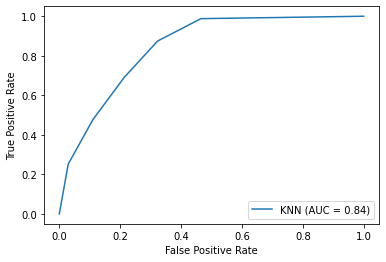

In [41]:
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='KNN')
display.plot()
plt.show()

### Grid Search CV

In [42]:
## Importing GridSearchCV

from sklearn.model_selection import GridSearchCV

## Creating a dictionary with hyperparameters and possible values 
## for searching

params = [{'n_neighbors': range(3,10), 'metric': ['euclidean', 'manhattan', 'chebyshev', 'canberra']}]

# chebyshek : chess board King's movement max[|(x1-x2)|, |(y1-y2)|]

## Configuring grid search

modelCV = GridSearchCV(KNeighborsClassifier(), params, cv=10, scoring='roc_auc')

## fit the search with training set
modelCV.fit(train_X, train_y)

# for distances refer - https://scikit-learn.org/dev/modules/generated/sklearn.metrics.DistanceMetric.html

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid=[{'metric': ['euclidean', 'manhattan', 'chebyshev',
                                     'canberra'],
                          'n_neighbors': range(3, 10)}],
             scoring='roc_auc')

In [43]:
modelCV.best_score_

0.8829591540268374

In [44]:
modelCV.best_params_

{'metric': 'canberra', 'n_neighbors': 3}

# Prediction

In [48]:
pred = modelCV.predict(test_X)

In [49]:
metrics.roc_auc_score(test_y, modelCV.predict_proba(test_X)[:,1])

0.8766587400177462